# Introduction

# Methods

## Data

The dataset used in this case study is a set of Monte Carlo simulations of signals for process that produce Higgs bosons and background processes that do not produce Higgs bosons\footnotemark\footnotetext{https://archive.ics.uci.edu/ml/datasets/HIGGS}.
The dataset contains 11 million instances of 28 features: 21 kenimatic properties measured by particle deterors in the accelerator and 7 engineered features.
The target variable is a binary indicator where 1 indicates a Higgs processes and 0 indicates a background process.
The reference paper indicates that the last 500,000 instances in this training set were used for model validation.
We maintained this train-validation split in this case study, using the last 500,000 instances for validation and the prior instances for training.

## Neural Network

### Replication of Model

In this case study, we replicated the modeling performed by Baldi, Sadowski, & Whiteson on the Higgs boson dataset with deep neural networks (DNN).
The model used in the reference study was a 5-layer multi-perceptron (MLP) with `tanh` activation, weight decay ($L2$ reularization) coefficient of $1 x 10^{5}$, and layers initialized with weights from the random normal. 
These hyperparamters are summerized in table 1.

**Table 1. Model Hyperparameters**



In addition to the model architecture, we also replicated the training process.
The model was trainined with stochastic gradient descent (SGD) with a batch size of 100.
The learning rate was initialized at 0.05 and decreased by a factor of 1.0000002 on each batch to a minumum rate of $1 x 10^{-6}$.
The momentum was initialized to 0.9 and increated linearly to 0.99 over 200 epochs, remaining constant after the 200th epoch.
For the stopping criterion, the reference paper indicates that early stopping with minimum change in error of 0.00001 over 10 epochs was used to determine when to stop the training process (resulting in training the model over 200-1000 epochs).
However, the reference paper does not indicate what error metric was monitored for early stopping.
We moitored the validation binary cross-entropy loss for early stopping as is typical practice in deep learning.
The training process is summerized in table 2.
In this study, the model was implemented with `TensorFlow`\footnotemark\footnotetext{https://pypi.org/project/tensorflow/2.2.0/} (version 2.2.0) because the framework used in the reference paper, `PyLearn2`\footnotemark\footnotetext{http://deeplearning.net/software/pylearn2/}, is no long actively maintained.


**Table 2. Model Training Parameters**

### Suggestions for Model Improvement

Include in your report:
Based on the class notes and discussion suggest improvements to the procedure. What are standard practices now versus when this paper was written? What kind of improvements do they provide?

Since the reference paper was published in 2014, there have been a number of notable advancements in the field of deep learning.
In this section, we suggest five potential improvements for this model and discuss the expected impact each improvement would provide.

* relu activation
* dropout
* ResNets (skip connections)
* optimizers: Adam, RMSprop
* layer initialization

# Results

training

![training curves](./images/training_history.png)

How would you quantify if your result duplicated the paper’s? **-> one sample t-test**

# Conclusions

# References

* \[1\] Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014). [https://arxiv.org/pdf/1402.4735.pdf](https://arxiv.org/pdf/1402.4735.pdf)

# Code

In [67]:
import pickle

import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
print(tf.__version__)

auc_score = tf.keras.metrics.AUC()
seed = 42

2.2.0


In [2]:
data = pd.read_csv('./data/HIGGS.csv', header = None)
# from the paper: The last 500,000 examples are used as a test set.
# The first column is the class label (1 for signal, 0 for background), followed by the 28 features
train_test_split = data.shape[0] - 500000
X_test = data.iloc[ train_test_split : , 1: ]
y_test = data.iloc[ train_test_split : , 0 ]
X_train = data.iloc[ : train_test_split , 1: ]
y_train = data.iloc[ : train_test_split , 0 ]

In [3]:
# helper functions

def create_model(hidden_size,
                 first_layer_init,
                 hidden_layer_init,
                 output_layer_init,
                 weight_decay,
                 starting_lr,
                 metrics,
                 ):
    """Create the model used in this case study
    """
    model = Sequential([
        layers.Dense(hidden_size, activation='tanh',
                    kernel_initializer=first_layer_init,
                    kernel_regularizer=l2(weight_decay),
                    dtype='float64'
                    ),
        layers.Dense(hidden_size, activation='tanh',
                    kernel_initializer=hidden_layer_init,
                    kernel_regularizer=l2(weight_decay),
                    dtype='float64'
                    ),
        layers.Dense(hidden_size, activation='tanh',
                    kernel_initializer=hidden_layer_init,
                    kernel_regularizer=l2(weight_decay),
                    dtype='float64'
                    ),
        layers.Dense(hidden_size, activation='tanh',
                    kernel_initializer=hidden_layer_init,
                    kernel_regularizer=l2(weight_decay),
                    dtype='float64'
                    ),
        layers.Dense(hidden_size, activation='tanh',
                    kernel_initializer=hidden_layer_init,
                    kernel_regularizer=l2(weight_decay),
                    dtype='float64'
                    ),
        layers.Dense(1, activation='sigmoid',
                    kernel_initializer=output_layer_init,
                    kernel_regularizer=l2(weight_decay),
                    dtype='float64'
                    )
    ])

    model.compile(optimizer=optimizers.SGD(lr=starting_lr),
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model



In [4]:
#We selected a five-layer neural
#network with 300 hidden units in each layer, a learning
#rate of 0.05, and a weight decay coefficient of 1 × 10−5

hidden_size = 300
starting_lr = 0.05
weight_decay = 1e-6

#Hidden units all used the tanh activation function.
#Weights were initialized from a normal distribution with
#zero mean and standard deviation 0.1 in the first layer,
#0.001 in the output layer, and 0.05 all other hidden layers. 
#Gradient computations were made on mini-batches
#of size 100. 

first_layer_init = initializers.RandomNormal(
    mean=0.0, stddev=0.1, seed=seed
)
hidden_layer_init = initializers.RandomNormal(
    mean=0.0, stddev=0.05, seed=seed
)
output_layer_init = initializers.RandomNormal(
    mean=0.0, stddev=0.001, seed=seed
)

In [109]:
model = create_model(hidden_size,
                     first_layer_init,
                     hidden_layer_init,
                     output_layer_init,
                     weight_decay,
                     starting_lr,
                     metrics=['accuracy',
                           auc_score])

In [110]:
# The learning rate decayed by a factor
#of 1.0000002 every batch update until it reached a minimum of 10−6
class LRSchedule(callbacks.Callback):
    """Lower the learning rate by a factor of 1.0000002 until the learning
    rate is at 1e-6 at which point it should remain constant
    """
    def on_batch_end(self, batch, logs):
        current_lr = K.get_value(model.optimizer.lr)
        if current_lr > 1e-6:
            lr = current_lr / 1.0000002 #1.00002
            K.set_value(self.model.optimizer.lr, lr)
        else:
            K.set_value(self.model.optimizer.lr, 1e-6)

lr_scheduler = LRSchedule()

In [111]:
#A momentum term increased linearly over
#the first 200 epochs from 0.9 to 0.99, at which point it
#remained constant. 

class MomentumSchedule(callbacks.Callback):
    """Update the momentum linearly from 0.9 to 0.99 between epochs 1 and 200 
    """
    def on_epoch_end(self, epoch, logs=None):
        starting_value = 0.9
        ending_value = 0.99
        number_epochs = 200
        step_increase = (ending_value-starting_value) / number_epochs
        if epoch > number_epochs:
            K.set_value(self.model.optimizer.momentum, ending_value)
        else:
            current_momentum = K.get_value(self.model.optimizer.momentum)
            current_momentum += step_increase
            K.set_value(self.model.optimizer.momentum, current_momentum)

momentum_scheduler = MomentumSchedule()

In [112]:
#Training ended when the momentum had reached its maximum value
#i.e. need to run for 200 epochs at least before stopping
#and the minimum error on
#the validation set (500,000 examples) had not decreased
#by more than a factor of 0.00001 over 10 epochs

class EarlyStoppingAfterMinEpoch(callbacks.Callback):
    """Stop training when a monitored metric has stopped improving and minimum number epochs has been reached.
    Primarily borrowed from:
    https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/callbacks.py#L1559-L1690
    """
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               min_epoch=200,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        super(EarlyStoppingAfterMinEpoch, self).__init__()

        self.monitor = monitor
        self.patience = patience
        self.min_epoch = min_epoch
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                      'fallback to auto mode.', mode)
        mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
    # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return
        if (epoch - self.min_epoch + self.patience) > 0:
            if self.verbose > 0:
                print('Started Monitor for Earing Stopping')
            if self.monitor_op(current - self.min_delta, self.best):
                self.best = current
                self.wait = 0
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of the best epoch.')
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                      'which is not available. Available metrics are: %s',
                      self.monitor, ','.join(list(logs.keys())))
        return monitor_value
            
early_stopping_criterion = EarlyStoppingAfterMinEpoch(
    monitor='val_loss',
    min_delta=0.00001,
    patience=10,
    verbose=1
)

In [113]:
hist = model.fit(X_train, y_train,
                 batch_size=100,
                 epochs=400,
                 validation_data=(X_test, y_test),
                 callbacks=[
                     lr_scheduler, momentum_scheduler, early_stopping_criterion
                 ]
                )

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

105000/105000 [==============================] - 546s 5ms/step - loss: 0.5442 - accuracy: 0.7185 - auc_2: 0.7957 - val_loss: 0.5033 - val_accuracy: 0.7483 - val_auc_2: 0.8313
Epoch 2/400
105000/105000 [==============================] - 541s 5ms/step - loss: 0.4969 - accuracy: 0.7533 - auc_2: 0.8360 - val_loss: 0.4888 - val_accuracy: 0.7585 - val_auc_2: 0.8422
Epoch 3/400
105000/105000 [==============================] - 539s 5ms/step - loss: 0.4868 - accuracy: 0.7601 - auc_2: 0.8437 - val_los

In [115]:
min_loss_loc = np.argmin(hist.history['val_loss'])

print('Best loss:', min(hist.history['val_loss']))
print('AUC:', hist.history['val_auc_2'][min_loss_loc])
print('Accuracy:', hist.history['val_accuracy'][min_loss_loc])

Best loss: 0.44971632957458496
AUC: 0.871549129486084
Accuracy: 0.7858020067214966


In [75]:
def plot_training_curves(history, title=None, caption=None, save_path=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history['val_loss'])
    min_loc = np.where(minimum == history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history['val_loss'] + history['loss']),
                          max(history['val_loss'] + history['loss']))
    acc_min, acc_max = (min(history['val_accuracy'] + history['accuracy']),
                        max(history['val_accuracy'] + history['accuracy']))
    # create figure
    fig, ax = plt.subplots(nrows=2, figsize = (7,10))
    fig.suptitle(title)
    index = np.arange(1, len(history['accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history['loss'], label = 'loss')
    ax[0].plot(index, history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history['accuracy'], label = 'accuracy')
    ax[1].plot(index, history['val_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    if caption is not None:
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
    plt.show()
    if save_path is not None:
        fig.savefig(save_path)

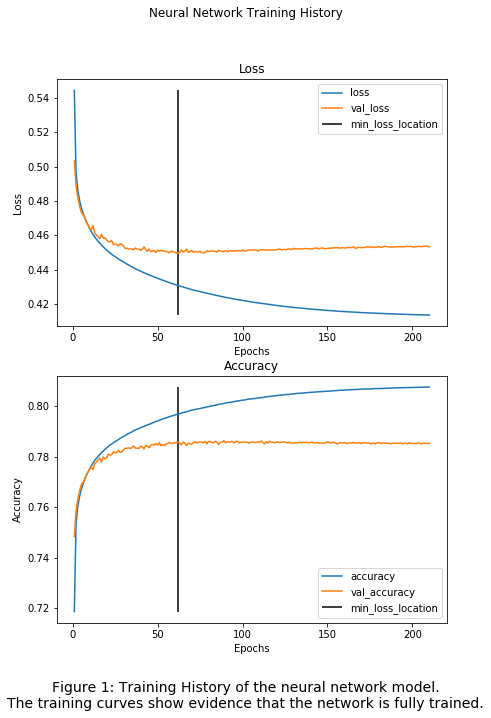

In [117]:
#with open('example_hist.pickle', 'wb') as f:
#    pickle.dump(hist.history, f)

# reload save training history
with open('example_hist.pickle', 'rb') as f:
    history = pickle.load(f)

caption = 'Figure 1: Training History of the neural network model.\n\
The training curves show evidence that the network is fully trained.'
plot_training_curves(history, title="Neural Network Training History",
                     caption=caption,
                     #save_path='./images/training_history.png'
                    )

In [102]:
# repeated runs of model with different seeds

repeated_runs_auc = [
    0.8732744455337524,
    0.871549129486084
    
]

repeated_runs_loss = [
    0.4477136433124542,
    0.44971632957458496
    
]

repeated_runs_acc = [
    0.7878699898719788,
    0.7858020067214966
    
]

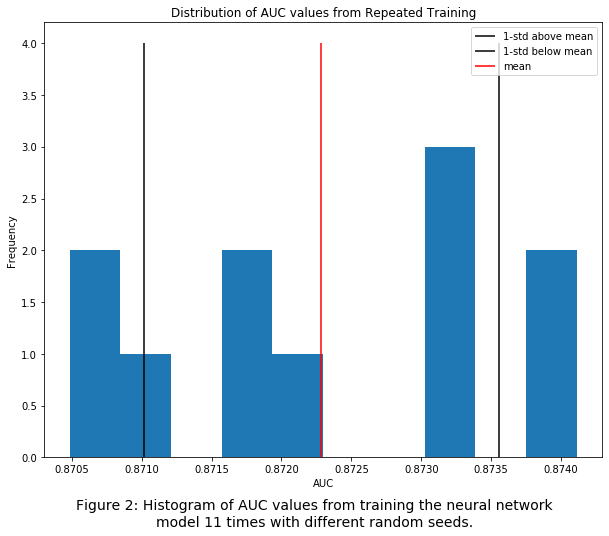

In [104]:
#just use this to up sample
runs = list()
#for _ in range(100):
#    runs.append(np.random.choice(repeated_runs_auc, 100).mean())
runs = runs + repeated_runs_auc

# plot the distributions of AUC

mean = np.mean(runs)
std = np.std(runs)

plt.figure(figsize=(10,8))
canvas = plt.hist(runs)
max_height = max(canvas[0])
plt.vlines(mean + std, 0, max_height+1, label = '1-std above mean')
plt.vlines(mean - std, 0, max_height+1, label = '1-std below mean')
plt.vlines(mean, 0, max_height+1, label = 'mean', color='r')
plt.title('Distribution of AUC values from Repeated Training')
plt.xlabel('AUC')
plt.ylabel('Frequency')

caption = 'Figure 2: Histogram of AUC values from training the neural network\n\
model ' + str(len(runs)) + ' times with different random seeds.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
# plot the reference from the paper
#plt.vlines(0.885, 0, max_height+1, label = 'reference mean', color='b')
plt.legend();

In [66]:
# test auc scores against mean from paper
ttest_1samp(runs, 0.885)

Ttest_1sampResult(statistic=-1621.3915628620043, pvalue=8.42881501362361e-227)